In [40]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import datetime
import pickle
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score,cross_validate,train_test_split
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [3]:
path = 'data/slv_working.pkl'
with open(path, 'rb') as f:
    slv_clean = pickle.load(f)

### Model 1: Removing trend/seasonality (Weekly)

In [4]:
weekly=slv_clean.resample('W').last()

In [5]:
deco = sm.tsa.seasonal_decompose(weekly['Close'],model='additive',period=3)
wk3_trend = deco.trend
wk3_seasonal = deco.seasonal
wk3_residual = deco.resid
wk3_residual.dropna(inplace=True)

In [6]:
data = wk3_residual

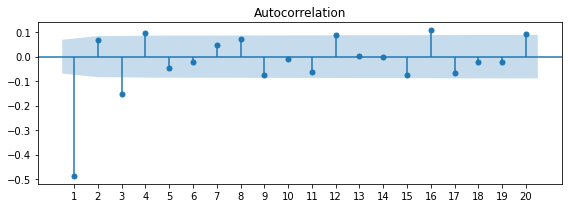

In [7]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
plot_acf(data,alpha=0.05,lags=np.arange(20)+1,ax=ax)
ax.set_xticks(np.arange(20)+1)
fig.tight_layout()

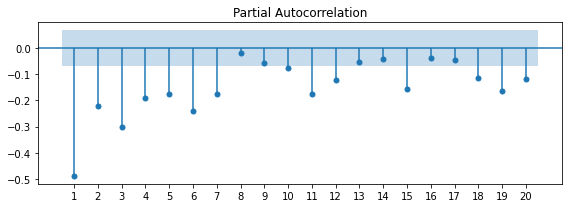

In [8]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
plot_pacf(data,alpha=0.05,lags=np.arange(20)+1,ax=ax)
ax.set_xticks(np.arange(20)+1)
fig.tight_layout()

**To model, we split the data into training and test sets. We use the first 80% of the data as the training set.**

In [9]:
train_ratio = 0.8
split = round(train_ratio * len(data))
train, test = data[0:split], data[split:]

In [10]:
metrics = []
for d in range(3):
    for p in range(7):
        for q in range(6):
            try:
                model = ARIMA(train,order=(p,d,q),trend='n')
                result = model.fit()
                metrics.append((p,d,q,result.aic,result.bic))
            except:
                pass
metr_resid = pd.DataFrame(metrics,columns=['p','d','q','AIC','BIC'])
metr_resid.sort_values('AIC').head()

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

,p,d,q,AIC,BIC
34,5,0,4,441.971930,486.648917
41,6,0,5,444.944286,498.556671
28,4,0,4,453.715517,493.924806
23,3,0,5,453.964599,494.173887
4,0,0,4,455.823129,478.161622


In [11]:
metr_resid.sort_values('BIC').head()

,p,d,q,AIC,BIC
1,0,0,1,468.753654,477.689051
4,0,0,4,455.823129,478.161622
19,3,0,1,457.764129,480.102623
7,1,0,1,468.889430,482.292527
2,0,0,2,468.947997,482.351093


#### **As explanatory models, the best models are the MA(1) and MA(4) models, but for forecasting we consider the ARMA(5,4) model.**

In [26]:
# ARMA(5,4)
arma504 = ARIMA(train,order=(5,0,4),trend='n')
res504 = arma504.fit()
print(res504.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  644
Model:                 ARIMA(5, 0, 4)   Log Likelihood                -210.986
Date:                Thu, 02 Dec 2021   AIC                            441.972
Time:                        10:09:30   BIC                            486.649
Sample:                    05-07-2006   HQIC                           459.308
                         - 09-02-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2645      0.160      1.658      0.097      -0.048       0.577
ar.L2         -0.9323      0.045    -20.901      0.000      -1.020      -0.845
ar.L3         -0.1139      0.160     -0.714      0.4

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


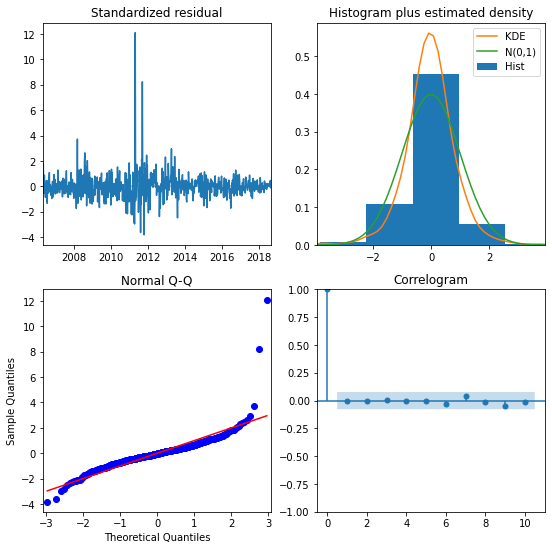

In [27]:
res504.plot_diagnostics(figsize=(9,9))
plt.show()

In [33]:
train.index[0]

Timestamp('2006-05-07 00:00:00', freq='W-SUN')

In [34]:
pred504 = res504.get_prediction(start=train.index[0],end=train.index[-1],dynamic=False)
pred504_ci = pred504.conf_int()

In [38]:
pred504_data = pred504.predicted_mean

In [39]:
pred504_data

Date
2006-05-07    0.000000
2006-05-14    0.049628
2006-05-21   -0.442714
2006-05-28    0.141669
2006-06-04   -0.147134
                ...   
2018-08-05   -0.043263
2018-08-12    0.012688
2018-08-19   -0.143103
2018-08-26   -0.002354
2018-09-02   -0.115003
Freq: W-SUN, Length: 644, dtype: float64

In [32]:
train.head()

Date
2006-05-07   -0.104282
2006-05-14    0.805753
2006-05-21   -0.663803
2006-05-28    0.179384
2006-06-04    0.190753
Freq: W-SUN, Name: resid, dtype: float64

In [ ]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [41]:
# ARMA(5,3) w/out lags 1 & 4 autoregressive
model = ARIMA(train,order=([2,3,5],0,3),trend='n')
arma503s = model.fit()
print(arma503s.summary())

                                 SARIMAX Results                                  
Dep. Variable:                      resid   No. Observations:                  644
Model:             ARIMA([2, 3, 5], 0, 3)   Log Likelihood                -217.348
Date:                    Fri, 03 Dec 2021   AIC                            448.696
Time:                            11:10:18   BIC                            479.970
Sample:                        05-07-2006   HQIC                           460.832
                             - 09-02-2018                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2         -0.9567      0.031    -30.439      0.000      -1.018      -0.895
ar.L3         -0.1212      0.048     -2.516      0.012      -0.216      -0.027
ar.L5         -0.149

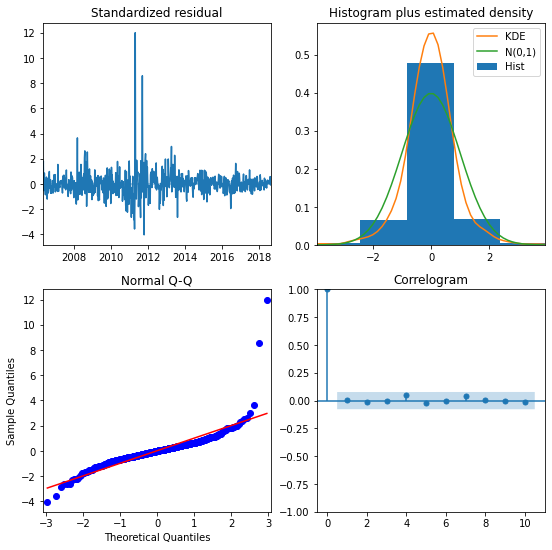

In [42]:
result.plot_diagnostics(figsize=(9,9))
plt.show()

In [16]:
metrics = []
d = 0
s = 3
for p in range(7):
    for q in range(6):
        for P in range(7):
            for D in range(2):
                for Q in range(6):
                    try:
                        model = ARIMA(train,order=(p,d,q),seasonal_order=(P,D,Q,s),trend='n')
                        result = model.fit()
                        metrics.append((p,d,q,P,D,Q,result.aic,result.bic))
                    except:
                        pass
metr_resid = pd.DataFrame(metrics,columns=['p','d','q','P','D','Q','AIC','BIC'])
metr_resid.sort_values('AIC').head()

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

,p,d,q,P,D,Q,AIC,BIC
277,0,0,4,6,0,0,440.592459,489.737145
1001,5,0,4,0,0,0,441.971930,486.648917
291,0,0,5,6,0,0,442.239570,495.851954
584,1,0,5,6,0,0,443.539569,501.619653
404,1,0,1,2,0,3,443.862775,479.604365


In [17]:
metr_resid.sort_values('BIC').head()

,p,d,q,P,D,Q,AIC,BIC
85,0,0,1,0,0,1,454.397742,467.800838
96,0,0,1,1,0,0,455.891092,469.294188
378,1,0,1,0,0,1,454.228333,472.099128
168,0,0,2,0,0,1,454.263344,472.134139
97,0,0,1,1,0,1,454.670267,472.541062


In [18]:
# SARIMA(0,0,4,(6,0,0,3))
model = ARIMA(train,order=(0,0,4),seasonal_order=(6,0,0,3),trend='n')
result = model.fit()
print(result.summary())

                                    SARIMAX Results                                     
Dep. Variable:                            resid   No. Observations:                  644
Model:             ARIMA(0, 0, 4)x(6, 0, [], 3)   Log Likelihood                -209.296
Date:                          Thu, 02 Dec 2021   AIC                            440.592
Time:                                  07:48:26   BIC                            489.737
Sample:                              05-07-2006   HQIC                           459.663
                                   - 09-02-2018                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9627      0.020    -47.474      0.000      -1.002      -0.923
ma.L2          0.0269      0.017      1.554      0.

In [19]:
model = ARIMA(train,order=(0,0,(1,0,1,1)),seasonal_order=((1,1,1,0,0,1),0,0,3),trend='n')
result = model.fit()
print(result.summary())

                                              SARIMAX Results                                              
Dep. Variable:                                               resid   No. Observations:                  644
Model:             ARIMA(0, 0, [1, 3, 4])x([1, 2, 3, 6], 0, [], 3)   Log Likelihood                -209.877
Date:                                             Thu, 02 Dec 2021   AIC                            435.754
Time:                                                     07:48:28   BIC                            471.495
Sample:                                                 05-07-2006   HQIC                           449.623
                                                      - 09-02-2018                                         
Covariance Type:                                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

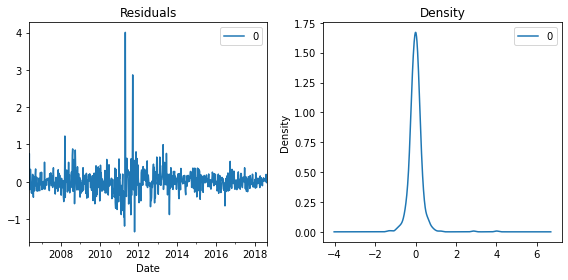

In [20]:
residuals = pd.DataFrame(result.resid)
fig, ax = plt.subplots(1,2,figsize=(8,4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.tight_layout()

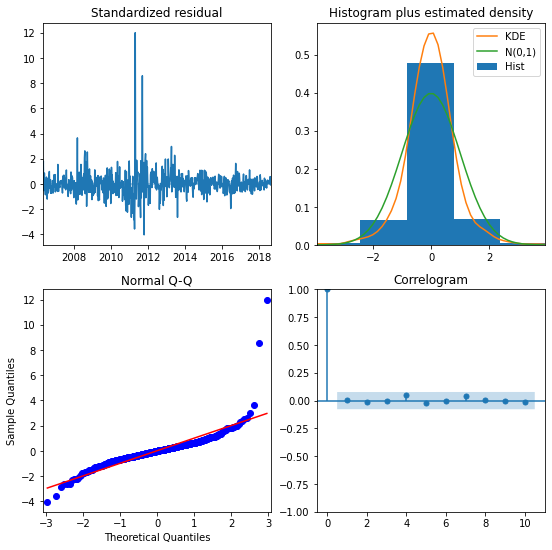

In [21]:
result.plot_diagnostics(figsize=(9,9))
plt.show()

In [22]:
residual = result.resid
from arch import arch_model

In [23]:
metrics = []
for p in range(7):
    for q in range(7):
        try:
            gmodel = arch_model(residual,p=p,q=q,mean='zero',vol='GARCH',dist='skewt')
            gresult = gmodel.fit(disp='off')
            metrics.append((p,q,gresult.aic,gresult.bic))
        except:
            pass
metr_resid = pd.DataFrame(metrics,columns=['p','q','AIC','BIC'])
metr_resid.sort_values('AIC').head()

,p,q,AIC,BIC
1,1,1,36.746048,59.084541
8,2,1,38.653723,65.459916
2,1,2,38.746048,65.552240
15,3,1,39.122695,70.396586
9,2,2,40.652043,71.925934


In [24]:
gmodel = arch_model(residual,p=1,q=1,mean='zero',vol='GARCH',dist='skewt')
gresult = gmodel.fit(disp='off')
gresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Zero Mean - GARCH Model Results                             
=========================================================================================
Dep. Variable:                              None   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.002
Vol Model:                                 GARCH   Log-Likelihood:               -13.3730
Distribution:      Standardized Skew Student's t   AIC:                           36.7460
Method:                       Maximum Likelihood   BIC:                           59.0845
                                                   No. Observations:                  644
Date:                           Thu, Dec 02 2021   Df Residuals:                      644
Time:                                   07:48:39   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.2005e-03  7.377e-04      1.627      0.104 [-2.454e-04,2.646e-03]
alpha[1]       0.0958  3.128e-02      3.063  2.188e-03    [3.452e-02,  0.157]
beta[1]        0.8907  2.887e-02     30.849 5.733e-209      [  0.834,  0.947]
                                Distribution                               
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
eta            5.4843      1.135      4.831  1.361e-06    [  3.259,  7.710]
lambda         0.0142  5.776e-02      0.245      0.806 [-9.903e-02,  0.127]
===========================================================================

Covariance estimator: robust
"""

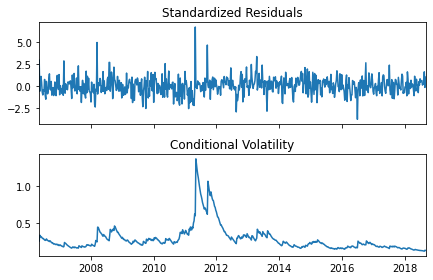

In [25]:
gresult.plot()
plt.tight_layout()

### Model 2: Differencing

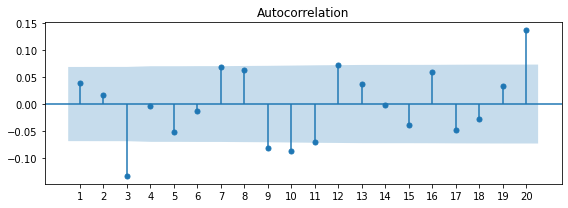

In [28]:
lags=20
x_ticks=np.arange(lags)+1
fig, ax = plt.subplots(1,1,figsize=(8,3))
slv_diff = weekly.diff().dropna()['Close']
plot_acf(slv_diff,alpha=0.05,lags=x_ticks, ax=ax)
ax.set_xticks(x_ticks)
fig.tight_layout()

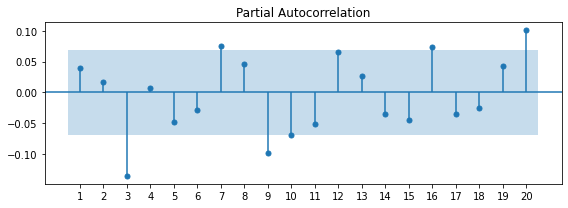

In [29]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
plot_pacf(slv_diff,alpha=0.05,lags=x_ticks, ax=ax)
ax.set_xticks(x_ticks)
fig.tight_layout()

In [32]:
metrics = []
for d in range(3):
    for p in range(7):
        for q in range(6):
            try:
                model = ARIMA(slv_diff,order=(p,d,q))
                result = model.fit(disp=0)
                metrics.append((p,d,q,result.aic,result.bic))
            except:
                pass
metr_diff = pd.DataFrame(metrics,columns=['p','d','q','AIC','BIC'])
metr_diff.sort_values('AIC').head()

,p,d,q,AIC,BIC
32,5,0,2,2253.581184,2295.809938
38,6,0,2,2255.172434,2302.093272
33,5,0,3,2255.285154,2302.205991
40,6,0,4,2255.486900,2311.791905
35,5,0,5,2255.878732,2312.183737


In [33]:
metr_diff.sort_values('BIC').head()

,p,d,q,AIC,BIC
0,0,0,0,2285.262837,2294.647004
32,5,0,2,2253.581184,2295.809938
3,0,0,3,2273.605851,2297.066270
18,3,0,0,2274.666666,2298.127085
17,2,0,5,2256.467467,2298.696221
